# This script will format graph databases


In [1]:
import sys
sys.path.append("../MIGraph/GraphConv/")

from ValueTransformer import ValueTransformer
from ConvGraphScript import drawGraph,checkGraphList
from AutoParameterScaling import AutoParameterScaling

import glob
import os
import joblib
from tqdm import tqdm
import numpy as np
import random


In [2]:
#load graph file
#graph files are saved in "input/***"
os.chdir("praparingGraphs")
fileList=glob.glob("input/autoPEDOTPSS/*")
fileList=fileList[0:1]
fileList

['input/autoPEDOTPSS\\PEDOT_PSS_autoprocessedGraph.graphbin']

# format graph
- check errors, etc

In [ ]:
class ValueTransformer:
    def __init__(self):
        self.mode=None
        #get parameter setting dictionary
        self.logDict,self.unitDict=loadParamDictCSV()
        self.paramList=list(self.logDict.keys())
        
    def setMode(self,mode):
        self.mode=mode
    
    #format values
    def transform(self,val):
        """
        val: node value
        return: formatted (cleaned) node value
        """
        doLog=self.logDict[self.mode]
        unit=self.unitDict[self.mode]
        ret=calcNodeValue(val,doLog )
        
        #caution for invalid values (inf, nan)
        if ret==-np.inf or ret==np.inf or np.isnan(ret):
            print(val,"inf or nan!","  graph number: ",self.cnum, "  node: ",self.cnode, "  unit: ",self.cunit)
            
        return ret
    
    #clean graphs
    def convertGraphList(self,graphList):
        """
        graphList: list of graph objects
        return cleaned graph objects
        """
        
        tempList=copy.deepcopy(graphList)
        for num,graph in enumerate(tqdm(tempList)):
            self.cnum=num

            #clean values for each units
            for unit in self.paramList:
                self.setMode(unit)
                self.cunit=unit
                nodeList=searchNodeIDforTargetUnit(graph,unit)
                
                for node in nodeList:
                    self.cnode=node
                    temp=self.transform(graph.nodes[node]["label"])        
                    graph.nodes[node]["label"]=temp
                    
                    if temp>1500:
                        print("warning! very large value:",temp, "graph number:",num, "node: ",node)
        
            #every word will converted to small letters
            try:
                lowerGraph(graph)
            except:
                print("error convert. num: ",num)
            
        return tempList


In [4]:
VT=ValueTransformer()
for filePath in fileList:

    print(filePath)
    gList=joblib.load(filePath)
    
    #convert unit etc
    gList=VT.convertGraphList(gList)
    checkGraphList(gList)
    
    trList=gList
    
    #保存
    filename=os.path.basename(filePath)
    outname="temporary/"+filename+".graphbin"
    print("saving...", outname)
    joblib.dump(trList,outname,compress=3)
    

input/autoPEDOTPSS\PEDOT_PSS_autoprocessedGraph.graphbin


100%|███████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 759.38it/s]


checking graph values...
check done
saving... temporary/PEDOT_PSS_autoprocessedGraph.graphbin.graphbin


# combine compound databases
- compound information is saved in 20191214pedotPSSautoCMP.csv
- in this demo, only one csv is available, but usually more csvs (see DEMO2,3)
- therefore, all compound files are combined at this step

In [8]:
import pandas as pd
#in the case of this PEDOT-PSS_txt project, only one compound file is available, but normally many)
allCompundsPath="output/allcompounds.csv.gz"

csvList=glob.glob("../convCSVtoGraph/temp/output/*.csv")
csvList2=glob.glob("input/*.csv")
csvgzList=glob.glob("input/*.csv.gz")

compPathList=sorted(list(set(csvList)|set(csvgzList)|set(csvList2)))
print(compPathList)

['input\\20191214pedotPSSautoCMP.csv']


In [9]:
CompColumns=["ID","SMILES"]

for num,filePath in enumerate(compPathList):
    print(filePath)
    if num==0:
        df=pd.read_csv(filePath)[CompColumns]
    else:
        df2=pd.read_csv(filePath)[CompColumns]
        df=pd.concat([df,df2],axis=0)
        
df=df.drop_duplicates("ID")
df=df[CompColumns].reset_index()
df.to_csv(allCompundsPath,index=False)
df

input\20191214pedotPSSautoCMP.csv


,index,ID,SMILES
0,0,C0001,[Mg]C1=C(OCCO2)C2=C([Mg])S1.[Mg]CC(C3=CC=C(S(O...
1,1,C0002,[H]O[H]
2,2,C0003,C(=O)(C(F)(F)F)C(F)(F)F.[H]O[H]
3,3,C0004,C(=O)(C(F)(F)F)C(F)(F)F
4,4,C0005,OS(O)(=O)=O
5,5,C0006,C[NH3+].[I-]
6,6,C0007,C[NH3+].[Br-]
7,7,C0008,CCO
8,8,C0009,CO
9,9,C0010,O=C(NC)C


# delete broken compounds and their graphs
- some compounds cannot be processed by a chemical library (RDKit)
- those compounds will be deleted

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem

compIDtoSMILES=dict(zip(df["ID"],df["SMILES"]))

graphbinList1=glob.glob("temporary/*.graphbin")
graphbinList2=glob.glob("../convCSVtoGraph/temp/output/*.graphbin")
graphbinList=sorted(list(set(graphbinList1)|set(graphbinList2)))


for graphbin in tqdm(graphbinList):
    gList=joblib.load(graphbin)
    ngList=[]
    
    for g in (gList):
        #extract comps
        compIDList=[g.nodes[node]["label"] for node in g.nodes if str(g.nodes[node]["label"])[:2]=="C_"]
        
        if np.nan in compIDList:
            compIDList=["none"]
            print("nan")
        
        if "C_nan" in compIDList:
            compIDList=["none"]
        
        #check if mol objects can be made from smiles
        try:
            SMILESList = [compIDtoSMILES[i[2:]] for i in compIDList]
            molList =[Chem.MolFromSmiles(smiles) for smiles in SMILESList]
            
            for mol in molList:
                morgan_fps =AllChem.GetMorganFingerprintAsBitVect(mol, 2, 20)
                bit=morgan_fps.ToBitString()

            ngList.append(g)
        except:
            print("error",SMILESList)
            
    joblib.dump(ngList,graphbin)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

error ['[Mg]C1=C(OCCO2)C2=C([Mg])S1.[Mg]CC(C3=CC=C(S(O)(=O)=O)C=C3)[Mg]', '[H]O[H]', '[Cl-].[Cl-].[Zn2+]', 'O=C(NC)C', '[H]O[H]']
error ['[Mg]C1=C(OCCO2)C2=C([Mg])S1.[Mg]CC(C3=CC=C(S(O)(=O)=O)C=C3)[Mg]', '[H]O[H]', '[Cl-].[Cl-].[Cu2+]', 'O=C(NC)C', '[H]O[H]']
error ['[Mg]C1=C(OCCO2)C2=C([Mg])S1.[Mg]CC(C3=CC=C(S(O)(=O)=O)C=C3)[Mg]', '[H]O[H]', '[Cl-].[Cl-].[Cl-].[In3+]', 'O=C(NC)C', '[H]O[H]']
error ['[Mg]C1=C(OCCO2)C2=C([Mg])S1.[Mg]CC(C3=CC=C(S(O)(=O)=O)C=C3)[Mg]', '[H]O[H]', '[Cl-].[Cl-].[Ni2+]', 'O=C(NC)C', '[H]O[H]']


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


# standardizing numeric values and finalize graphs
- standardizing is not necessary for this demo, because it was done at step 0
- however, normally done at this step (see DEMO 2 and 3)
- standardization is done for each parameters (if a parameter was not found, "fit failed" error appears, but not problematic)

In [12]:
graphbinList1=glob.glob("temporary/*.graphbin")
graphbinList2=glob.glob("../convCSVtoGraph/temp/output/*.graphbin")
graphbinList=sorted(list(set(graphbinList1)|set(graphbinList2)))
print(graphbinList)

AutoSC=AutoParameterScaling()
AutoSC.initialize(graphbinList)
joblib.dump(AutoSC,"output/AutoSC.scaler",compress=3)
AutoSC.autoTransform(graphbinList)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

['temporary\\PEDOT_PSS_autoprocessedGraph.graphbin.graphbin']
loading files


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

fitting scalers
fit failed:  absolute molar magnetic susceptibility
fit failed:  absolute standard enthalpy of formation
fit failed:  amorphous density
fit failed:  amorphous thermal conductivity
fit failed:  band gap
fit failed:  simulated band gap
fit failed:  boiling temperature
fit failed:  simulated highest occupied molecular orbital
fit failed:  simulated lowest unoccupied molecular orbital
fit failed:  broad peak
fit failed:  converted oxidation potential (v vs nhe)
fit failed:  converted oxidation/reduction potential (v vs nhe)
fit failed:  converted reduction potential (v vs nhe)
fit failed:  crystalline density
fit failed:  crystalline thermal conductivity
fit failed:  density
fit failed:  dipole moment
fit failed:  simulated dipole moment
fit failed:  flash temperature
fit failed:  glass expansivity
fit failed:  glass transition temperature
fit failed:  heat capacity
fit failed:  ionic conductivity
fit failed:  ionization energy
fit failed:  liquid expansivity
fit failed:  l

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


# check graphs

In [13]:
graphbinList=glob.glob("output/*.graphbin")

gList=[]
for file in tqdm(graphbinList):
    print(file)
    temp=joblib.load(file)
    gList.extend(temp)

print(len(gList), " plots")

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

output\PEDOT_PSS_autoprocessedGraph.graphbin.graphbin


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]

336  plots


['mixture',
 'spincoated',
 '-',
 -0.18102082380937723,
 'percent',
 'weight',
 'C_C0001',
 'ph_thousand',
 'percent',
 0.9060944440473682,
 'weight',
 'C_C0002',
 'kept',
 'minutes',
 '-',
 -0.3601303457914896,
 'celsius',
 -0.7973113009791734,
 'dropped',
 'mixture',
 '-',
 -1.8906981756684318,
 'percent',
 'weight',
 'C_C0004',
 'percent',
 -0.8073840101468494,
 'weight',
 'C_C0002',
 'kept',
 'minutes',
 '-',
 0.000986086440284967,
 'celsius',
 -0.13954406145547849,
 'rinsed',
 'C_C0002',
 'kept',
 'minutes',
 '-',
 0.000986086440284967,
 'celsius',
 -0.13954406145547849,
 'gave',
 'electric conductivity',
 '[s/cm]',
 -0.6530024676689811]

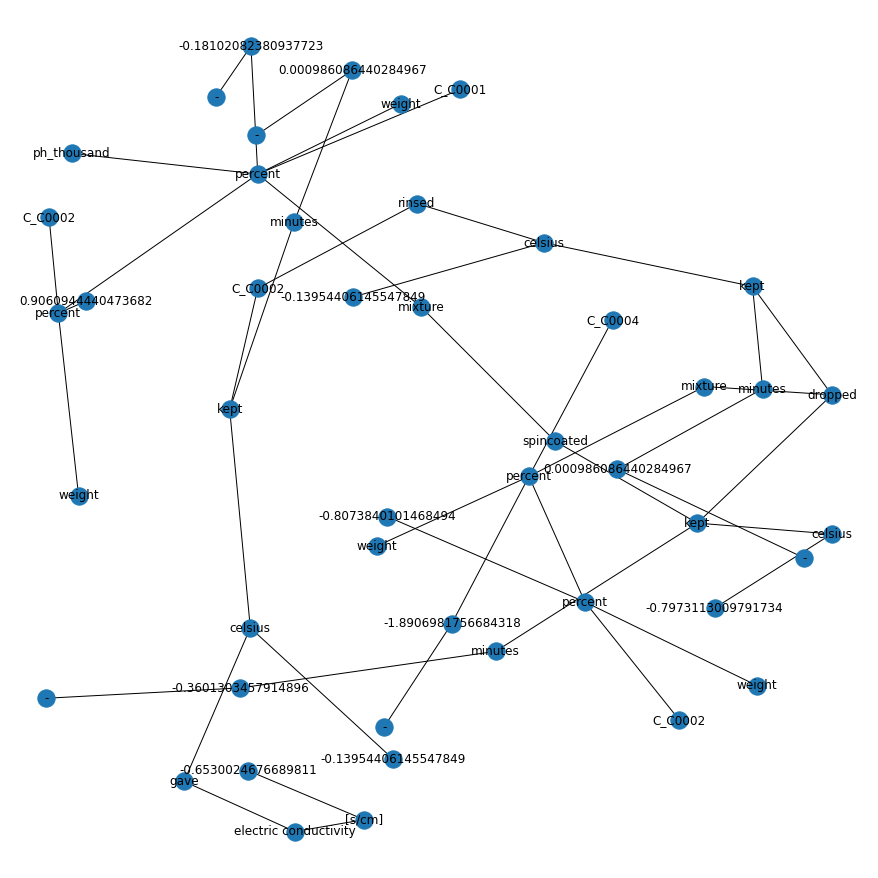

In [18]:
number=1

#draw
drawGraph(gList[number])
g=gList[number]
nodeVals=[g.nodes[node]["label"] for node in g.nodes]
nodeVals